<h2><font color="#004D7F" size=5>Módulo 2: Bootstrap Aggregation</font></h2>


<h1><font color="#004D7F" size=6>8. Data Transform Bagging </font></h1>
<br><br>
<div style="text-align: right">
<font color="#004D7F" size=3>Manuel Castillo-Cara</font><br>
<font color="#004D7F" size=3>Aprendizaje Automático II</font><br>
<font color="#004D7F" size=3>Universidad Nacional de Educación a Distancia</font>

</div>

---

<a id="indice"></a>
<h2><font color="#004D7F" size=5>Índice</font></h2>


* [1. Algoritmo de conjunto Data Transform Bagging](#section1)
    * [1.1. Bagging y Random Forest Vs. Extra Trees](#section11)
    * [1.2. Hiperparámetros de Extra Trees](#section12)
* [2. Data Transform Ensemble para clasificación](#section2)
    * [2.1. Dataset](#section21)
    * [2.2. Estudio de línea base](#section22)
    * [2.3. CART de conjunto](#section23)
    * [2.4. Comparación con miembros contribuyentes](#section24)
* [3. Data Transform Ensemble para regresión](#section3)
    * [3.1. Dataset](#section31)
    * [3.2. Estudio de línea base](#section32)
    * [3.3. CART de conjunto](#section33)
* [Ejercicios](#sectionEj)

---

<a id="section0"></a>
# <font color="#004D7F">0. Contexto</font>

- La agregación Bootstrap (Bagging) es un conjunto en el que cada modelo se entrena en una muestra diferente del conjunto de datos de entrenamiento.
- Un enfoque es utilizar transformaciones de datos que cambian la escala y la distribución de probabilidad de las variables de entrada como base para el entrenamiento de los miembros contribuyentes a un conjunto similar a Bagging. 

En este tutorial, descubrirá cómo desarrollar un conjunto de transformación de datos. Después de completar este tutorial, sabrá:
- Las transformaciones de datos se pueden utilizar como base para un conjunto de tipo Bagging donde el mismo modelo se entrena en diferentes vistas de un conjunto de datos de entrenamiento.
- Cómo desarrollar un conjunto de transformación de datos para clasificar y confirmar el conjunto se desempeña mejor que cualquier miembro contribuyente.
- Cómo desarrollar y evaluar un conjunto de transformación de datos para el modelado predictivo de regresión.

---
<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></font></a>
</div>

---

<a id="section1"></a>
# <font color="#004D7F"> 1. Algoritmo de Data Transform Bagging</font>

- Fue diseñado para usarse con árboles de decisión y cada muestra de datos se realiza utilizando el método bootstrap (selección con reemplazo), el enfoque ha generado todo un subcampo de estudio con cientos de variaciones del enfoque.
- La idea es que pequeñas diferencias en el conjunto de datos de entrenamiento utilizado para ajustar cada modelo den como resultado pequeñas diferencias en las capacidades de los modelos.
- Para el aprendizaje en conjunto, esto se conoce como __diversidad de miembros del conjunto__ y tiene como __objetivo descorrelacionar las predicciones__ (o errores de predicción) realizadas por cada miembro contribuyente. 

- Construcción de conjuntos Bagging: Se pueden crear conjuntos Bagging personalizados al cambiar el conjunto de datos usado para el aprendizaje de cada miembro contribuyente.
- Enfoque propuesto: Aplicar diferentes transformaciones de preparación de datos a cada miembro del conjunto contribuyente.
- Necesidad de evaluación: Se motiva la evaluación de modelos con una variedad de transformaciones de datos, como la modificación de escala y distribución de probabilidad, para determinar qué estrategias son efectivas.

### _Data Transform Bagging_ o _Data Transform Ensemble_: 
Este enfoque se puede utilizar cuando se crea un conjunto de diferentes transformaciones del mismo conjunto de datos de entrenamiento, se entrena un modelo en cada una y las predicciones se combinan utilizando estadísticas simples como el promedio.
Hay muchas transformaciones que podemos usar, pero quizás un buen punto de partida sería una selección que cambie la escala y la distribución de probabilidad, como por ejemplo:
- Normalización (rango fijo).
- Estandarización (media cero).
- Estandarización robusta (robusta frente a valores atípicos).
- Transformación de potencia (eliminar la inclinación).
- Transformada cuantil (distribución de cambios).
- Discretización (_k-­bins_).

Resumiendo:
- El enfoque es más eficaz cuando se usa con un modelo base que entrena diferentes o muy diferentes modelos según los efectos de la transformación de datos.
- Cambiar la escala de la distribución es apropiado con modelos sensibles a cambios en la escala de las variables de entrada, como la regresión logística, redes neuronales, KNN y máquinas de vectores de soporte.
- Los cambios en la distribución de probabilidad de las variables de entrada probablemente afectarían a la mayoría de los modelos de aprendizaje automático.

---
<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></font></a>
</div>

---

<a id="section2"></a> 
# <font color="#004D7F"> 2. Data Transform Ensemble para clasificación</font>

Cada miembro del conjunto se puede definir como un `Pipeline`, con la transformación seguida por el modelo predictivo.
Finalmente, se puede utilizar un conjunto de votación para combinar las predicciones de cada canal.

<a id="section21"></a> 
## <font color="#004D7F"> 2.1. Dataset</font>

Primero, podemos usar la función `make_classification()` para crear un problema de clasificación binaria sintética con 1000 ejemplos y 20 características de entrada. El ejemplo completo se enumera a continuación.

In [1]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=1)
print(X.shape, y.shape)

(1000, 20) (1000,)


<a id="section22"></a> 
## <font color="#004D7F"> 2.2. Estudio de línea base</font>

Establecemos una línea de base:
- Es una práctica estándar utilizar un árbol de decisión en conjuntos de Bagging, por lo que en este caso usaremos `DecisionTreeClassifier` con hiperparámetros predeterminados.
- Evaluaremos el modelo utilizando prácticas estándar, en este caso, validación cruzada estratificada repetida de _k_ veces con 3 repeticiones y 10 pliegues.


<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> __Nota__: Más información sobre la clase [`DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
</div>

In [2]:
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy medio: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy medio: 0.822 (0.043)


<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> __Nota__: Sus resultados pueden variar dada la naturaleza estocástica del algoritmo o procedimiento de evaluación, o diferencias en la precisión numérica. Considere ejecutar el ejemplo varias veces y comparar el resultado promedio.
</div>

<a id="section23"></a> 
## <font color="#004D7F"> 2.3. CART de conjunto</font>

A continuación, podemos desarrollar un conjunto de árboles de decisión, cada uno de los cuales se ajusta a una transformación diferente de los datos de entrada. 

- Definimmos cada miembro del conjunto como un pipeline de modelado. El primer paso será la transformación de datos y el segundo será un clasificador de árbol de decisión. Por ejemplo, el Pipeline para una transformación de normalización con la clase `MinMaxScaler`.
- Podemos repetir esto para cada transformación o configuración de transformación que queramos usar y agregar todas los pipeline del modelo a una lista.
- La clase `VotingClassifier` se puede utilizar para combinar las predicciones de todos los modelos.
- El conjunto de votantes simplemente promedia las predicciones hechas por los miembros contribuyentes.
- Esta clase toma un argumento `estimators` que es una lista de tuplas donde cada tupla tiene un nombre y el modelo o proceso de modelado.
- Para que el código sea más fácil de leer, podemos definir una función `get_ensemble()` para crear el Los miembros y los datos transforman el conjunto mismo.

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> __Nota__: Más información sobre la clase [`VotingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html)
</div>

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> __Nota__: Más información sobre la clase [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)
</div>

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> __Nota__: Más información sobre todas las clases de de [Preprocesamiento de datos](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing)
</div>

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline

def get_ensemble():
	# definir la lista de modelos
	models = list()
	# Normalización
	norm = Pipeline(steps=[('s', MinMaxScaler()), ('m', DecisionTreeClassifier())])
	models.append(('norm', norm))
	# estandardización
	std = Pipeline(steps=[('s', StandardScaler()), ('m', DecisionTreeClassifier())])
	models.append(('std', std))
	# Scalamiento robust
	rbs = Pipeline(steps=[('s', RobustScaler()), ('m', DecisionTreeClassifier())])
	models.append(('rbs', rbs))
	# Yeo-Johnson
	yj = Pipeline(steps=[('s', PowerTransformer()), ('m', DecisionTreeClassifier())])
	models.append(('yj', yj))
	# Cuartiles
	qt = Pipeline(steps=[('s', QuantileTransformer()), ('m', DecisionTreeClassifier())])
	models.append(('qt', qt))
	# kbins
	kb = Pipeline(steps=[('s', KBinsDiscretizer()), ('m', DecisionTreeClassifier())])
	models.append(('kb', kb))
	# definimos el voto del conjunto
	ensemble = VotingClassifier(estimators=models, voting='hard')
	return ensemble

Luego podemos llamar a esta función y evaluar el conjunto de votación como de costumbre, tal como lo hicimos hizo para el árbol de decisión anterior. Uniendo esto, el ejemplo completo se enumera a continuación.

In [4]:
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

# obtener los ensembles
ensemble = get_ensemble()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(ensemble, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy medio: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy medio: 0.836 (0.042)


<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> __Nota__: Sus resultados pueden variar dada la naturaleza estocástica del algoritmo o procedimiento de evaluación, o diferencias en la precisión numérica. Considere ejecutar el ejemplo varias veces y comparar el resultado promedio.
</div>

<a id="section24"></a> 
## <font color="#004D7F"> 2.4. Comparación con miembros contribuyentes</font>

Aunque el conjunto tuvo un buen desempeño en comparación con un único árbol de decisión, una limitación de esta prueba es que no sabemos si el conjunto tuvo un mejor desempeño que cualquier miembro contribuyente. Esto es importante, ya que si un miembro que contribuye al conjunto se desempeña mejor, entonces sería más sencillo y fácil utilizar al propio miembro como modelo en lugar del conjunto. 

Podemos comprobar esto evaluando el rendimiento de cada modelo individual y comparando los resultados con el conjunto. Primero, podemos actualizar la función `get_ensemble()` para devolver una lista de modelos para evaluar compuesta por los miembros individuales del conjunto así como el conjunto mismo.

In [5]:
def get_ensemble():
	models = list()
	norm = Pipeline([('s', MinMaxScaler()), ('m', DecisionTreeClassifier())])
	models.append(('norm', norm))
	st = Pipeline([('s', StandardScaler()), ('m', DecisionTreeClassifier())])
	models.append(('std', st))
	robust = Pipeline([('s', RobustScaler()), ('m', DecisionTreeClassifier())])
	models.append(('robust', robust))
	power = Pipeline([('s', PowerTransformer()), ('m', DecisionTreeClassifier())])
	models.append(('power', power))
	quant = Pipeline([('s', QuantileTransformer(n_quantiles=100, output_distribution='normal')), ('m', DecisionTreeClassifier())])
	models.append(('quant', quant))
	kbins = Pipeline([('s', KBinsDiscretizer(n_bins=20, encode='ordinal')), ('m', DecisionTreeClassifier())])
	models.append(('kbins', kbins))
	ensemble = VotingClassifier(estimators=models, voting='hard')
	# devolver la lista de nombre modelo
	return models + [('ensemble', ensemble)]

Podemos llamar a esta función y enumerar cada modelo, evaluarlo, informar el rendimiento, y almacenar los resultados.

Finalmente, podemos trazar la distribución de las puntuaciones de accuracy como diagramas de caja y bigotes uno al lado del otro y comparar la distribución de las puntuaciones directamente. Visualmente, esperaríamos que la distribución de las puntuaciones del conjunto sea mayor que la de cualquier miembro individual

In [6]:
from matplotlib import pyplot

# obtener los modelos
models = get_ensemble()
# Evaluación de los modelos
results = list()
for name, model in models:
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	# almacenar modelos
	results.append(n_scores)
	print('>%s: %.3f (%.3f)' % (name, mean(n_scores), std(n_scores)))

>norm: 0.823 (0.042)
>std: 0.829 (0.040)
>robust: 0.825 (0.046)
>power: 0.825 (0.043)
>quant: 0.818 (0.041)
>kbins: 0.829 (0.037)
>ensemble: 0.830 (0.043)


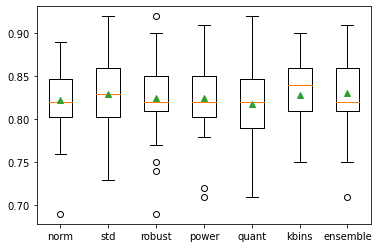

In [7]:
pyplot.boxplot(results, labels=[n for n,_ in models], showmeans=True)
pyplot.show()

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> __Nota__: Sus resultados pueden variar dada la naturaleza estocástica del algoritmo o procedimiento de evaluación, o diferencias en la precisión numérica. Considere ejecutar el ejemplo varias veces y comparar el resultado promedio.
</div>

---
<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></font></a>
</div>

---

<a id="section3"></a> 
# <font color="#004D7F"> 3. Data Transform Ensemble para regresión</font>

En esta sección, exploraremos el desarrollo de un conjunto de transformación de datos para un problema de modelado predictivo de regresión.

<a id="section31"></a> 
## <font color="#004D7F"> 3.1. Dataset</font>

Primero, podemos usar la función `make_classification()` para crear un problema de clasificación binaria sintética con 1000 ejemplos y 20 características de entrada. El ejemplo completo se enumera a continuación.

In [8]:
from sklearn.datasets import make_regression
X, y = make_regression(n_samples=1000, n_features=100, n_informative=10, noise=0.1, random_state=1)
print(X.shape, y.shape)

(1000, 100) (1000,)


<a id="section32"></a> 
## <font color="#004D7F"> 3.2. Estudio de línea base</font>

A continuación, podemos establecer una línea de base
- En este caso, un `DecisionTreeRegressor`.
- Evaluaremos el modelo utilizando prácticas estándar, en este caso, validación cruzada estratificada repetida de _k_ veces con 3 repeticiones y 10 pliegues.

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> __Nota__: Más información sobre la clase [`DecisionTreeRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)
</div>

In [10]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RepeatedKFold

model = DecisionTreeRegressor()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

MAE: -141.348 (12.542)


<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> __Nota__: La API de scikit-learn invierte el signo del MAE para transformarlo, de minimizar el error a maximizar el error negativo. Esto significa que los errores positivos de gran magnitud se convierten en grandes errores negativos (por ejemplo, 100 se convierte en -100) y un modelo perfecto no tiene ningún error con un valor de 0,0. También significa que podemos ignorar con seguridad el signo de las puntuaciones MAE medias. 

</div>

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> __Nota__: Sus resultados pueden variar dada la naturaleza estocástica del algoritmo o procedimiento de evaluación, o diferencias en la precisión numérica. Considere ejecutar el ejemplo varias veces y comparar el resultado promedio.
</div>

<a id="section33"></a> 
## <font color="#004D7F"> 3.3. CART de conjunto</font>

A continuación, podemos desarrollar y evaluar el conjunto. 
- Usaremos las mismas transformaciones de datos de la sección anterior.
- Se utilizará `VotingRegressor` para combinar las predicciones, lo cual es apropiado para problemas de regresión.
- La función `get_ensemble()` definida a continuación crea los modelos individuales y el modelo de conjunto y combina todos los modelos como una lista de tuplas para su evaluación.

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> __Nota__: Más información sobre la clase [`VotingRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingRegressor.html)
</div>

In [16]:
from sklearn.ensemble import VotingRegressor

def get_ensemble():
	models = list()
	norm = Pipeline([('s', MinMaxScaler()), ('m', DecisionTreeRegressor())])
	models.append(('norm', norm))
	st = Pipeline([('s', StandardScaler()), ('m', DecisionTreeRegressor())])
	models.append(('std', st))
	robust = Pipeline([('s', RobustScaler()), ('m', DecisionTreeRegressor())])
	models.append(('robust', robust))
	power = Pipeline([('s', PowerTransformer()), ('m', DecisionTreeRegressor())])
	models.append(('power', power))
	quant = Pipeline([('s', QuantileTransformer(n_quantiles=100, output_distribution='normal')), ('m', DecisionTreeRegressor())])
	models.append(('quant', quant))
	kbins = Pipeline([('s', KBinsDiscretizer(n_bins=20, encode='ordinal')), ('m', DecisionTreeRegressor())])
	models.append(('kbins', kbins))
    # voting
	ensemble = VotingRegressor(estimators=models)
	# devuelve la tupa
	return models + [('ensemble', ensemble)]

Luego podemos llamar a esta función y evaluar cada canal de modelado contribuyente de forma independiente y comparar los resultados con el conjunto de los canales. Nuestra expectativa, como antes, es que el conjunto dé como resultado un aumento en el rendimiento con respecto a cualquier modelo individual. Si no es así, entonces se debería elegir el modelo individual de mayor rendimiento. 

Uniendo todo esto, a continuación se enumera el ejemplo completo para evaluar un conjunto de transformación de datos para un conjunto de datos de regresión.

In [17]:
from matplotlib import pyplot

# obtener modelos
models = get_ensemble()
# evaluar cada modelo
results = list()
for name, model in models:
	cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
	n_scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
	# almacenar resultados
	results.append(n_scores)
	print('>%s: %.3f (%.3f)' % (name, mean(n_scores), std(n_scores)))

>norm: -141.775 (11.991)
>std: -140.597 (11.363)
>robust: -140.608 (10.954)
>power: -141.781 (13.753)
>quant: -141.406 (12.244)
>kbins: -145.809 (12.756)
>ensemble: -126.016 (10.207)


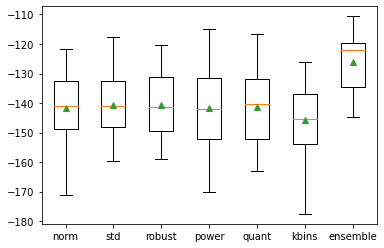

In [18]:
pyplot.boxplot(results, labels=[n for n,_ in models], showmeans=True)
pyplot.show()

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> __Nota__: Sus resultados pueden variar dada la naturaleza estocástica del algoritmo o procedimiento de evaluación, o diferencias en la precisión numérica. Considere ejecutar el ejemplo varias veces y comparar el resultado promedio.
</div>

---
<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></font></a>
</div>

---

<a id="sectionEj"></a>
<h3><font color="#004D7F" size=6> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#113D68"></i> Ejercicios</font></h3>

Se proponen las siguientes actividades para consolidar el aprendizaje.

# <font color="#004D7F" size=5>Ejercicio 1</font>
__Hiperparámetros__. Explore diferentes configuraciones que veas en la librerías vistas ya sean de Preprocesamiento de datos o propias de los algoritmos utilizados y comente los resultados. 

# <font color="#004D7F" size=5>Ejercicio 2</font>
__Preprocesamiento de datos__. En Scikit-learn se encuentran otras muchas clases sobre procesamiento de datos. Utilice alguna de ellas comentado su impacto y resultados al utilizarlas.

# <font color="#004D7F" size=5>Ejercicio 3</font>
__Datasets reales__. Busque un dataset original y verdadero (que no sea sintético) y evalúe el uso de los conceptos vistos en esta unidad. Los conjuntos de datos en pueden ser obtenidos del [repositorio de aprendizaje automático de UCI](https://archive.ics.uci.edu/).

# <font color="#004D7F" size=5>Ejercicio 4</font>
__Voto__. Busque otras técnicas en cuanto al algoritmo de voto y evalúe su impacto, de manera teória y práctica.

# <font color="#004D7F" size=5>Ejercicio 5</font>
__Búsqueda de la mejor configuración__. Como se ha visto existen diferentes hiperparámetros que pueden ajustar nuestro modelo. Haga una búsqueda para un dataset real de cuales, entre un rango amplio de hiperparétros, maximizan la métrica. Puede utilizar una búsqueda aleatoria.

# <font color="#004D7F" size=5>Ejercicio 6</font>
__Métodos Bagging__. Explore qué otros métodos Bagging se encuentran en la literatura y desarrolle este nuevo método a imagen y semejanza de cómo lo hemos visto, pero para un dataset real.

---

<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></font></a>
</div>

---

<div style="text-align: right"> <font size=6><i class="fa fa-coffee" aria-hidden="true" style="color:#004D7F"></i> </font></div>